In [1]:
import util as u
import pandas as pd

data='/labs/mpsnyder/moqri/data/index/'


In [5]:
v='38'

bws={
'h9':'http://smithdata.usc.edu/methbase/data/Xie-Human-2013/Human_H9/tracks_hg'+v+'/Human_H9.meth.bw',
'ips':'http://smithdata.usc.edu/methbase/data/Lister-iPSC-2011/Human_FFiPSC69/tracks_hg'+v+'/Human_FFiPSC69.meth.bw',
'ct':'http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-100yr/tracks_hg'+v+'/Human_CD4T-100yr.meth.bw',
'nb':'http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-Newborn/tracks_hg'+v+'/Human_CD4T-Newborn.meth.bw',
'so':'http://smithdata.usc.edu/methbase/data/Vandiver-Human-2015/Human_Epidermis-old-sun-exposed/tracks_hg'+v+'/Human_Epidermis-old-sun-exposed.meth.bw',
'sy':'http://smithdata.usc.edu/methbase/data/Vandiver-Human-2015/Human_Epidermis-young-sun-exposed/tracks_hg'+v+'/Human_Epidermis-young-sun-exposed.meth.bw'
}
bws={
'md':'http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_PBMC/tracks_hg'+v+'/Human_PBMC.meth.bw'
}

In [32]:
tss=pd.read_csv('files/tss38.csv',index_col=0)
tss.shape

(31335, 8)

In [7]:
# bigwigs
cells=bws.keys()
for cell in cells:
    bw_url=bws[cell]
    df=u.bw2df(bw_url,tss)
    df.to_csv(data+'wg/'+cell+'.csv')

1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.2.2.2.2.2.2.2.2.2.2.3.3.3.3.3.3.3.4.4.4.4.4.4.4.5.5.5.5.5.5.5.5.6.6.6.6.6.6.6.6.7.7.7.7.7.7.7.8.8.8.8.8.8.8.9.9.9.9.9.10.10.10.10.10.10.11.11.11.11.11.11.11.11.11.11.12.12.12.12.12.12.12.12.12.13.13.13.14.14.14.14.14.14.15.15.15.15.15.15.16.16.16.16.16.16.16.16.17.17.17.17.17.17.17.17.17.17.18.18.18.18.19.19.19.19.19.19.19.19.19.19.20.20.20.20.21.21.22.22.22.22.(3153046, 1)


In [16]:
# bed files
normal='https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1421nnn/GSM1421901/suppl/GSM1421901_Normal_CD19_1WGBS.hg19.bed.txt.gz'
!wget -nc -q {normal}  -O "{data}/cancer/bc1.bed.gz"
cancer='https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1421nnn/GSM1421900/suppl/GSM1421900_CLL007WGBS.hg19.bed.txt.gz'
!wget -nc -q {cancer}  -O "{data}/cancer/bcl1.bed.gz"

2021-12-01 10:18:53 [INFO]  Read the chain file "hg19ToHg38.over.chain.gz" 


In [77]:
no=pd.read_table(data+'cancer/bc1.bed.gz')
ca=pd.read_table(data+'cancer/bcl1.bed.gz')
no.index=no['chr'].str[3:]+'_'+no['start'].astype(str)
ca.index=ca['chr'].str[3:]+'_'+ca['start'].astype(str)
com=no.index.intersection(ca.index)
len(com)
no=no.loc[com]
ca=ca.loc[com]
no['n']=no['methylatedReadCount']/(no['methylatedReadCount']+no['unmethylatedReadCount'])
ca['c']=ca['methylatedReadCount']/(ca['methylatedReadCount']+ca['unmethylatedReadCount'])
no['c']=ca['c']
no['end']=no['start']
no=no[['chr','start','end','n','c']]
no.to_csv(data+'cancer/bc_19.bed',header=False,index=False,sep='\t')
!CrossMap.py bed hg19ToHg38.over.chain.gz "{data}cancer/bc_19.bed" "{data}cancer/bc_38.bed"

2021-12-01 11:24:51 [INFO]  Read the chain file "hg19ToHg38.over.chain.gz" 


In [78]:
df=pd.read_csv(data+'wg/cpgs.csv',index_col=0)

In [79]:
ca=pd.read_table(data+'/cancer/bc_38.bed',header=None)
print(len(ca)/(10**6))
ca.columns=['chr','b1','b2','n','c']
ca.index=ca['chr'].str[3:]+'_'+ca['b1'].astype(str)
ca=ca[ca.index.isin(df.index)]
ca=ca.drop_duplicates()
ca=ca[~ca.index.duplicated()]

6.204562


In [80]:
ca[ca.index.isin(df.index)][['n','c']].mean()

n    0.240041
c    0.231926
dtype: float64

In [83]:
df=df.merge(ca[['n','c']],left_index=True,right_index=True,how='left')

In [84]:
df=df.dropna()
df.shape

(1799962, 7)

In [85]:
df[['beta','n','c']].mean()

beta    0.245116
n       0.240041
c       0.231926
dtype: float64

(1285818, 7)


<ipython-input-86-40fe7470293a>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ((dl.drop(['g','tss','d','dq'],1)>.2).sum()/len(dl)).plot(kind='bar')


<AxesSubplot:>

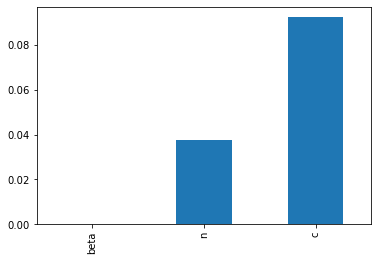

In [86]:
dl=df[df.beta<.2]
print(dl.shape)
((dl.drop(['g','tss','d','dq'],1)>.2).sum()/len(dl)).plot(kind='bar') 

In [87]:
df['dq']=pd.qcut(df.d,11)

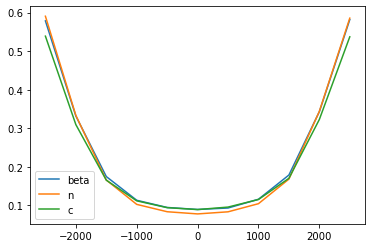

In [88]:
import seaborn as sns

pl=df.groupby('dq').mean()[['beta','n','c']]
pl.index=list(range(-2500,2501,500))
ax=sns.lineplot(data=pl,dashes=False)